In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 24.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from transformers import pipeline

from nltk import sent_tokenize
import nltk
from time import time
import matplotlib.pyplot as plt
import torch

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Load Dataset

In [ ]:
substitles_paths = sorted(glob("data/Subtitles/*.ass"))

In [ ]:
scripts = []
episode_num = []
for path in substitles_paths:
    
    with open(path,'r') as file:
        lines = file.readlines()
        lines = lines[27:]
    
        rows = [",".join(line.split(',')[9:]) for line in lines]
        
    rows = [line.replace("\\N",' ') for line in rows]
    script = " ".join(rows)
    
    episode = int(path.split('-')[1].split('.')[0].strip())
    
    scripts.append(script)
    episode_num.append(episode)

In [ ]:
df = pd.DataFrame.from_dict({'episode':episode_num,'script':scripts})

In [ ]:
df.head()

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


# Load Model

In [ ]:
device = 0 if torch.cuda.is_available() else 'cpu'

In [ ]:
from transformers import pipeline
theme_classifier = pipeline("zero-shot-classification",
                      model= 'facebook/bart-large-mnli',
                      device=device)

In [ ]:
theme_classifier("I have a problem with my iphone that needs to be resolved asap!",
    candidate_labels=["urgent", "not urgent", "phone", "tablet", "computer"],
    multi_label=False
)

{'sequence': 'I have a problem with my iphone that needs to be resolved asap!',
 'labels': ['urgent', 'phone', 'computer', 'not urgent', 'tablet'],
 'scores': [0.5227579474449158,
  0.45813998579978943,
  0.014264940284192562,
  0.002685009967535734,
  0.0021520734298974276]}

# Inference

In [ ]:
def get_themes(script):
    script_sentences = sent_tokenize(script)

    # Batch sentences 
    script_batches = []
    sentence_batch_size=20
    for index in range(0,len(script_sentences),sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)
    
    # Run model
    candidate_labels = ['friendship','hope', 'sacrifice', 'battle','self development','betrayal','love','dialogue'] 
    emotion_output = theme_classifier(script_batches, 
                       candidate_labels,multi_label=True)

    # Wrangle Output    
    emotions={}
    for output in  emotion_output:
        for label, score in zip(output['labels'],output['scores']):
            if label not in emotions:
                emotions[label]=[]
            emotions[label].append(score)
    
    emotions =  {key:np.mean(np.array(value)) for key,value in emotions.items()}
   
    return emotions

In [ ]:
output_emotions = df['script'].apply(get_themes)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:646: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x7fd4c2714f10> was reported to be 10 (when accessing len(dataloader)), but 17 samples have been fetched. 
  warnings.warn(warn_msg)
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:646: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x7fd4c2714f10> was reported to be 10 (when accessing len(dataloader)), but 18 samples have been fetched. 
  warnings.warn(warn_msg)
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:646: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x7fd4c2714f10> was reported to be 10 (when accessing len(dataloader)), but 19 samples have been fetched. 
  warnings.warn(warn_msg)
/usr/local/li

In [ ]:
emotion_df = pd.DataFrame(output_emotions.tolist())

In [ ]:
emotion_df.head()

,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,0.933066,0.843436,0.730703,0.738852,0.786690,0.356777,0.270746,0.171008
1,0.878907,0.523089,0.614091,0.560678,0.723522,0.360577,0.199374,0.126210
2,0.914471,0.591376,0.700835,0.721964,0.739589,0.379513,0.339813,0.260938
3,0.704726,0.346729,0.641507,0.494499,0.496159,0.230442,0.110953,0.133850
4,0.818597,0.680574,0.750627,0.708856,0.653921,0.301845,0.238132,0.113576


In [ ]:
df[emotion_df.columns] = emotion_df

In [ ]:
theme_output = df.drop(['episode','script','dialogue'],axis=1).sum().reset_index()
theme_output.columns = ['theme','score']
theme_output

,theme,score
0,betrayal,123.675060
1,battle,154.715143
2,sacrifice,158.352502
3,self development,145.778323
4,hope,89.345955
5,friendship,75.649607
6,love,46.516728


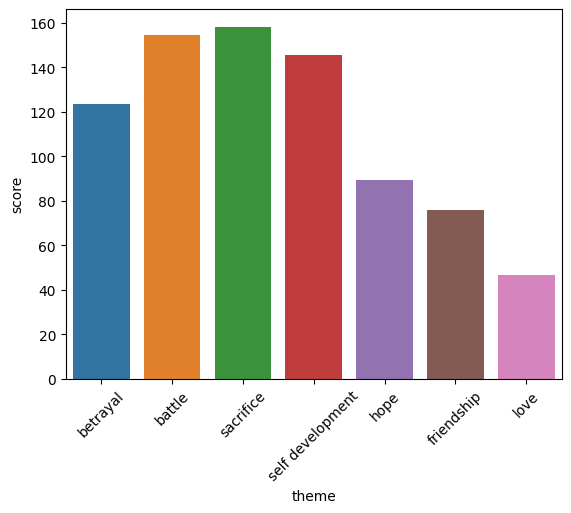

In [ ]:
import seaborn as sns
sns.barplot(data=theme_output, x="theme", y="score")
plt.xticks(rotation=45)
plt.show()